## 난 스케치를 할 테니 너는 채색을 하거라
### Segmentation map으로 도로 이미지 만들기

### [ 목   차 ]

1. 데이터 불러오기 및 전처리
2. Augmentation 적용
3. EncodeBlock, DecodeBlock 구현
4. U-Net Genetor 구현
5. DiscBlock 구현
6. Discriminator 구현
7. 손실함수 및 옵티마이저 구성
8. 학 습
9. 결 론

[ 회 고 ]

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras import layers, Input, Model
from tensorflow.keras import optimizers, losses
from tensorflow import data
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import time
import imageio
from IPython import display

### 1. 데이터 불러오기 및 전처리

In [3]:
data_dir = '/content/drive/MyDrive/LMS/E_16'
train_path = os.path.join(data_dir, 'cityscapes/train/')
test_path = os.path.join(data_dir, 'cityscapes/val/')
print("number of train examples :", len(os.listdir(train_path))) 
print("number of test examples :", len(os.listdir(test_path))) 

number of train examples : 1000
number of test examples : 5


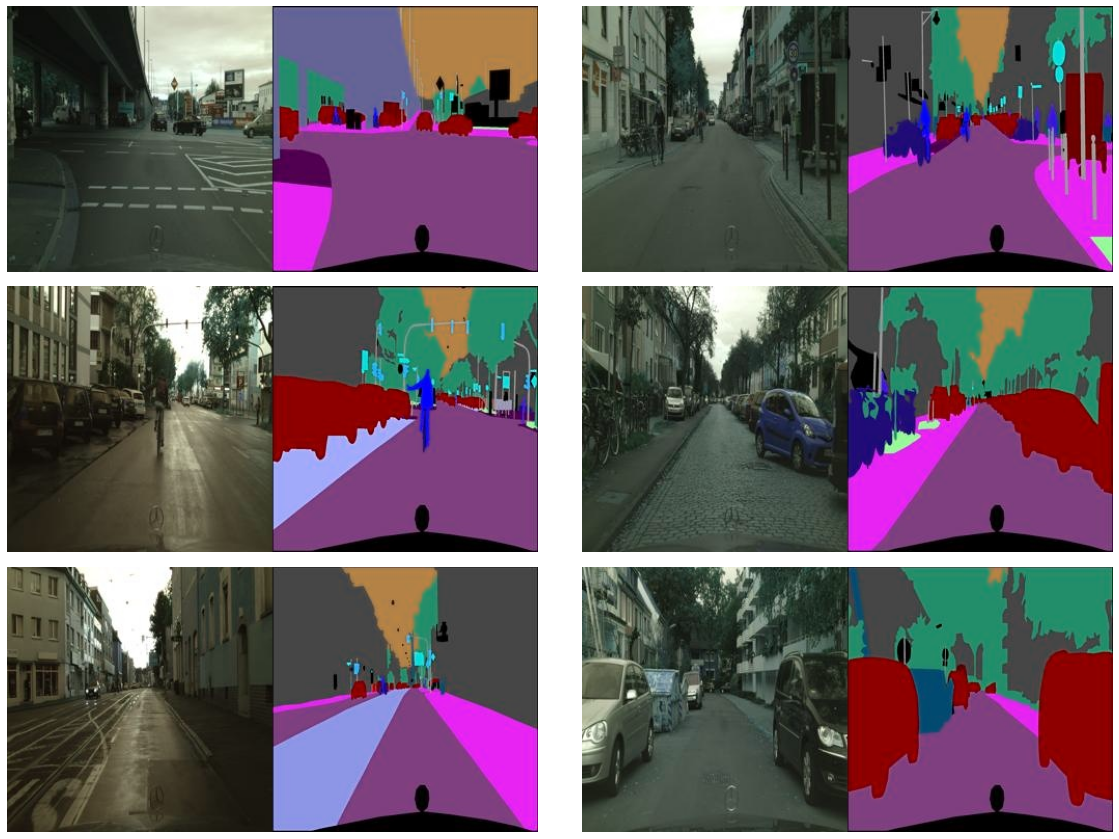

In [4]:
# 학습용 데이터셋에서 임의로 6장 선택하여 시각화

plt.figure(figsize=(16,12))
for i in range(1, 7):
    f = train_path + os.listdir(train_path)[np.random.randint(1000)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.tight_layout()
    plt.axis('off')
    plt.imshow(img)

In [5]:
# 이미지 크기 확인

f = train_path + os.listdir(train_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)  

(256, 512, 3)


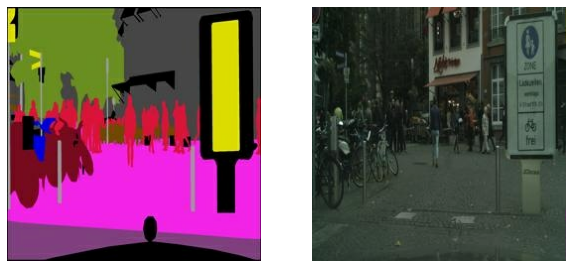

In [6]:
# 이미지 나누기

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    real_image = img[:, :w, :] 
    real_image = tf.cast(real_image, tf.float32)
    input_image = img[:, w:, :] 
    input_image = tf.cast(input_image, tf.float32)
    return normalize(input_image), normalize(real_image)

f = train_path + os.listdir(train_path)[1]
input_image, real_image = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.axis('off'); plt.imshow(denormalize(input_image))
plt.subplot(1,2,2); plt.axis('off'); plt.imshow(denormalize(real_image))

### 2. Augmentation 적용

In [7]:
# 함수구성

@tf.function() #빠른 텐서플로 연산을 위해 @tf.function()을 사용.
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]

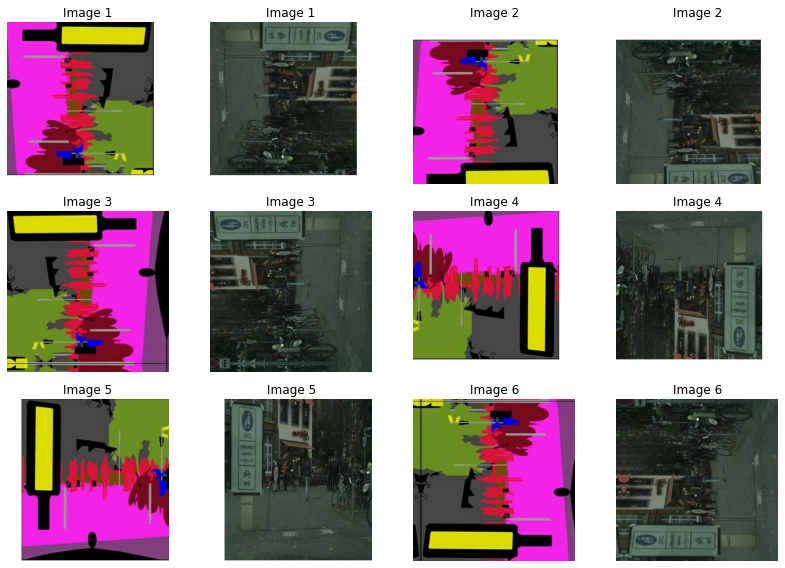

In [8]:
# augmentation 적용 후 시각화

plt.figure(figsize=(12,8))
img_n = 1
for i in range(1, 13, 2):
    augmented_input, augmented_real = apply_augmentation(input_image, real_image)
    
    plt.subplot(3,4,i)
    plt.axis('off'); plt.imshow(denormalize(augmented_input)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1) 
    plt.axis('off'); plt.imshow(denormalize(augmented_real)); plt.title(f"Image {img_n}")
    plt.tight_layout()
    img_n += 1

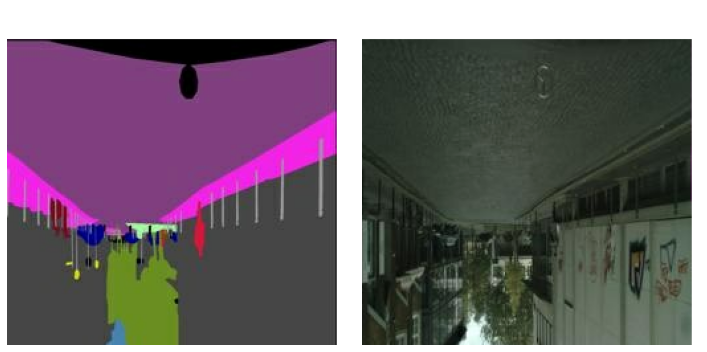

In [9]:
# augmentation 적용 함수구성

def get_train(img_path):
    input_image, real_image = load_img(img_path)
    input_image, real_image = apply_augmentation(input_image, real_image)
    return input_image, real_image

train_images = data.Dataset.list_files(train_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
input_image, real_image = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.axis('off'); plt.imshow(input_image[0].astype(np.uint8))
plt.subplot(1,2,2); plt.axis('off'); plt.imshow(real_image[0].astype(np.uint8))
plt.tight_layout()

### 3. EncodeBlock, DecodeBlock 구현

In [10]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


### 4. U-Net Generator 구현

In [11]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [12]:
generator = UNetGenerator()
generator.get_summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block (EncodeBlock)     (None, 128, 128, 64  3072        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 encode_block_1 (EncodeBlock)   (None, 64, 64, 128)  131584      ['encode_block[0][0]']           
                                                                                              

### 5. DiscBlock 구현

In [13]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


### 6. Discriminator 구현

In [14]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [15]:
discriminator = Discriminator()
discriminator.get_summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

### 7. 손실함수 및 옵티마이저 구성

In [16]:
# 손실 함수

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


In [17]:
# 옵티마이저 구성

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


### 8. 학 습

In [18]:
# 1개 배치 데이터 입력했을 때 가중치 1회 업데이트

@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss)  # L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


In [19]:
# 생성 이미지 저장

def generate_and_save_images(model, epoch, it, save_file_num=1):

    plt.figure(figsize=(16,8))
    for train_idx in range(len(os.listdir(train_path))//100):
        f = train_path + os.listdir(train_path)[train_idx]
        input_image, real_image = load_img(f)

        pred = generator(tf.expand_dims(input_image, 0))
        pred = denormalize(pred)

        plt.subplot(2, 5, train_idx+1)  # 10개 sample 
        plt.imshow(pred[0])
        plt.axis('off')

    plt.tight_layout()  # subplot 간격 자동 조절(겹치지 않게)

    save_file_path = os.path.join(data_dir, 'cityscapes/generated_samples/sample_{}'.format(save_file_num))
    if not os.path.exists(save_file_path):
        os.makedirs(save_file_path)
    
    save_file_path = os.path.join(save_file_path, 'sample_epoch_{:04d}_iter_{:03d}.png'.format(epoch, it))
    plt.savefig(save_file_path)  # 이미지 저장

    plt.show()

In [20]:
# history 그리기

def draw_train_history(history, epoch, save_file_num=1):
    plt.figure(figsize=(15,15))

    plt.subplot(411)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')

    plt.subplot(412)  
    plt.plot(history['gen_loss'], 'tab:blue')   
    plt.title('gen_loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss'], loc='upper left')

    plt.subplot(413)  
    plt.plot(history['l1_loss'], 'tab:green')   
    plt.title('l1_loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['l1_loss'], loc='upper left')  

    plt.subplot(414)  
    plt.plot(history['disc_loss'], 'tab:orange')   
    plt.title('disc_loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['disc_loss'], loc='upper left')  

    plt.tight_layout()  # subplot 간격 자동 조절(겹치지 않게)

    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    save_file_path = os.path.join(data_dir, 'cityscapes/training_history/training_history_{}'.format(save_file_num))
    if not os.path.exists(save_file_path):
        os.makedirs(save_file_path)
    
    save_file_path = os.path.join(save_file_path, 'training_history_{:04d}.png'.format(epoch))
    plt.savefig(save_file_path)  # 이미지 저장

    plt.show()

In [21]:
# 체크포인트 설정

checkpoint = tf.train.Checkpoint(generator_optimizer=gene_opt,
                                 discriminator_optimizer=disc_opt,
                                 generator=generator,
                                 discriminator=discriminator)

In [22]:
# 학습 진행

def train(dataset, epochs, save_every, save_file_num=1):
    start = time.time()
    history = {'gen_loss':[], 'l1_loss':[], 'disc_loss':[]}
    for epoch in range(1, epochs+1):
        epoch_start = time.time()
        for i, (input_image, ground_truth) in enumerate(train_images):
            g_loss, l1_loss, d_loss = train_step(input_image, ground_truth)
            history['gen_loss'].append(g_loss)
            history['l1_loss'].append(l1_loss)
            history['disc_loss'].append(d_loss)
                    
            # 200회 반복마다 손실을 출력합니다.
            if (i+1) % 200 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, i+1, save_file_num)
                print(f"EPOCH[{epoch+1}] - STEP[{i+1}] \
                        \nTime for epoch {epoch} : {int(time.time()-epoch_start)} sec \
                        \nGenerator_loss:{g_loss.numpy():.4f} \
                        \nL1_loss:{l1_loss.numpy():.4f} \
                        \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")
                
        if (epoch + 1) % save_every == 0:
            checkpoint_dir = os.path.join(data_dir, 'cityscapes/training_checkpoints/training_checkpoints_{}'.format(save_file_num))
            checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, i, save_file_num)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch, save_file_num)

In [23]:
save_every = 10  # 모델 저장 간격
EPOCHS = 100  # 학습 횟수
save_file_num = 1

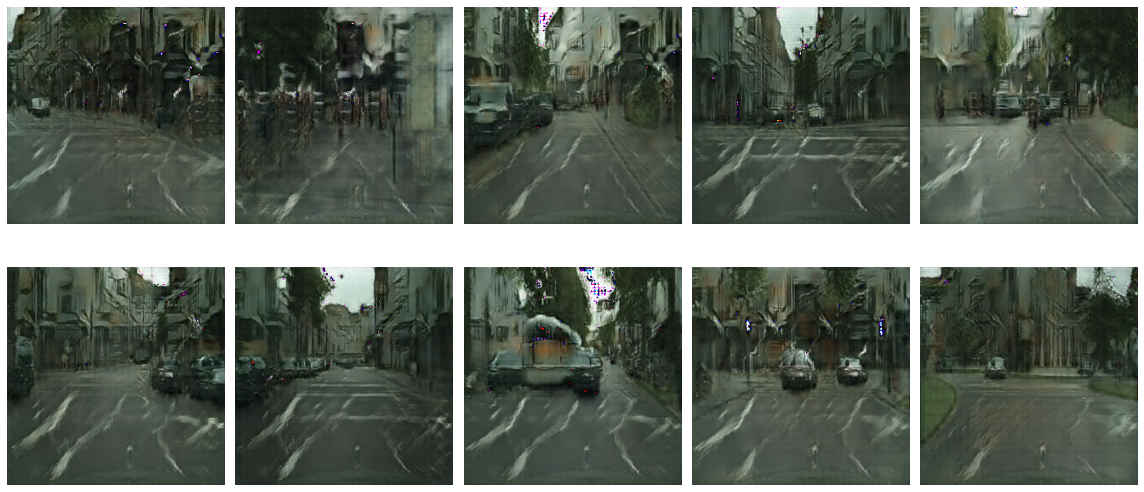

Time for training : 2940 sec


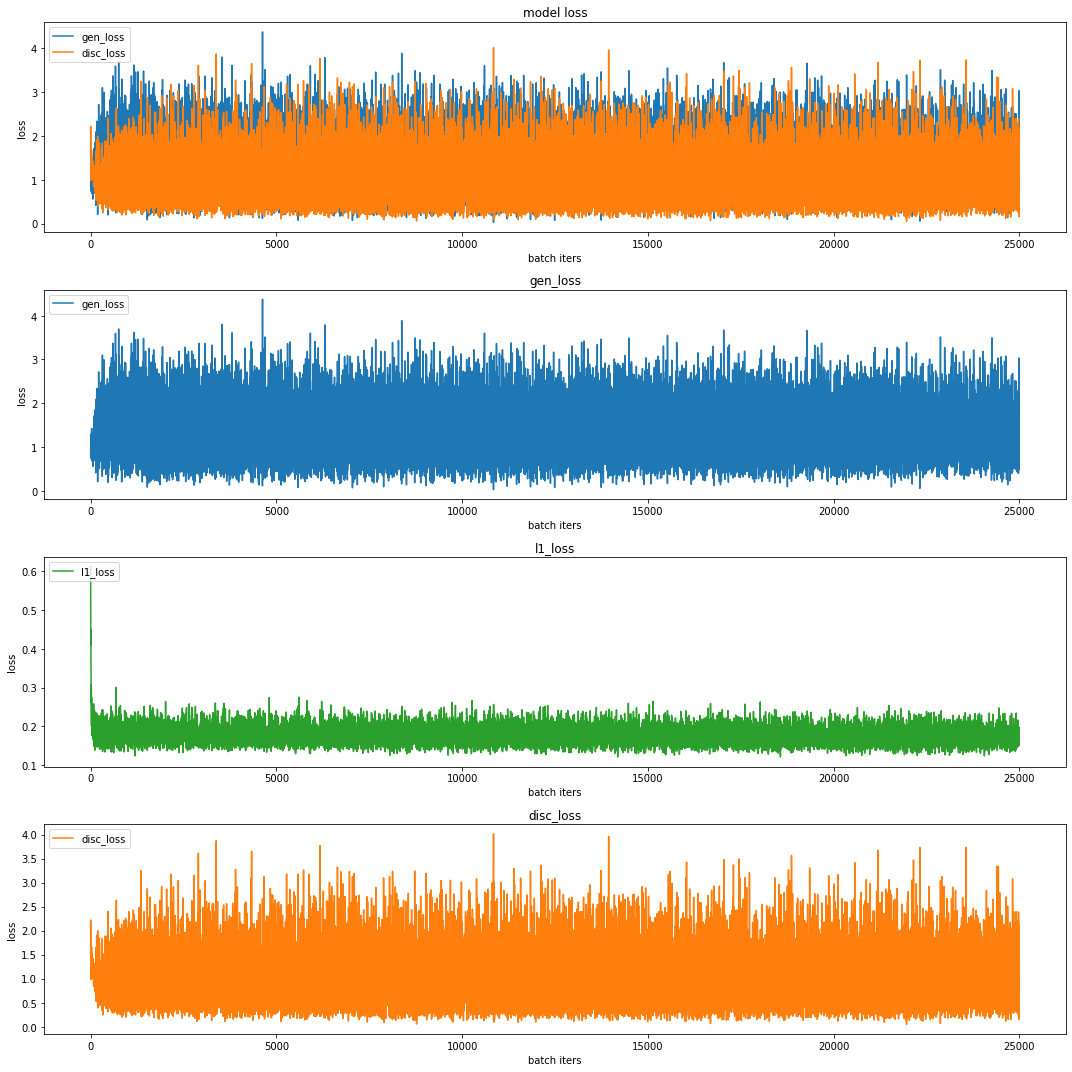

CPU times: user 49min 18s, sys: 3min, total: 52min 18s
Wall time: 49min 3s


In [24]:
%%time
train(train_images, EPOCHS, save_every, save_file_num)

In [31]:
# 체크포인트 불러와서 결과 확인 : test data 5건

def draw_training_checkpoints_image(save_file_num=1):
    checkpoint_dir = os.path.join(data_dir, 'cityscapes/training_checkpoints/training_checkpoints_{}'.format(save_file_num))
    latest = tf.train.latest_checkpoint(checkpoint_dir)
    checkpoint.restore(latest)

    generator = checkpoint.generator
    discriminator = checkpoint.discriminator

    # 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
    for test_idx in range(len(os.listdir(test_path))):
        f = test_path + os.listdir(test_path)[test_idx]
        input_image, real_image = load_img(f)

        pred = generator(tf.expand_dims(input_image, 0))
        pred = denormalize(pred)

        plt.figure(figsize=(18,6))
        
        plt.subplot(1,3,1); plt.axis('off'); plt.imshow(denormalize(input_image)); plt.title('Input Image')
        plt.subplot(1,3,2); plt.axis('off'); plt.imshow(pred[0]); plt.title('Predicted Image', fontsize=13)
        plt.subplot(1,3,3); plt.axis('off'); plt.imshow(denormalize(real_image)); plt.title('Ground Truth')

        plt.tight_layout()  
        plt.show()  

In [32]:
draw_training_checkpoints_image(1)

Output hidden; open in https://colab.research.google.com to view.

### 9. 결 론
  * pix2pix 테스트 결과 100번의 epoch에서 산출된 이미지는 실제 이미지와 다소 차이 있음
  * 전반적으로 loss값이 미세하게 하락하나, 하락 폭이 미미한 수준임
  * epoch수를 500 이상으로 하고, Layer층을 더 쌓는다면 결과는 개선될 것으로 보임


#### [ 회  고  ]
  * 단순 Gan 보다는 cGan이 실 활용도는 더 높을 것 같음
  * 최근 인기를 끄는 DALI-E 도 일종의 conditional Gan으로 볼 수 있음
  * 생성 이미지를 직접 활용하기 어렵더라도, 참고로 새로운 착상의 역할 가능할 것 같음(디자인 등)
  * Gan의 종류가 많다고 하는데 어떤 것들이 있는지 살펴보아야겠음
  * pix2pix 모듈이 있는 것 같음(from tensorflow_examples.models.pix2pix import pix2pix)


< reference>
  * https://www.tensorflow.org/tutorials/generative/pix2pix?hl=ko
  * https://deep-learning-study.tistory.com/645

